# Perform one sample test in control cells

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [5]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.shape

(69958, 36588)

### Setup memento

In [7]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [8]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [9]:
memento.setup_memento(adata, q_column='q')

In [10]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


In [11]:
adata.uns['memento'].keys()

dict_keys(['q_column', 'all_q', 'estimator_type', 'filter_mean_thresh', 'num_bins', 'least_variable_genes', 'all_1d_moments'])

### Perform one sample test on ciliated, control cells

In [12]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [14]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [15]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    7.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   16.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   28.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   42.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   59.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.2min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.7min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  3.2min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  3.8min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  4.5min
[Parallel(n_jobs=13)]: Done 9774 tasks      | elapsed:  5.2min
[Parallel(n_jobs=13)]: Done 10150 out of 1015

In [16]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [17]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [18]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef < 0').gene.tolist()

In [19]:
# for gene in hv_genes:
#     print(gene)

In [23]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
5204,IFIT2,-0.469849,0.126272,4.148413e-04,2.978472,0.268455,1.186644e-06,0.000161
5205,IFIT3,-0.020981,0.074616,7.867213e-01,2.309936,0.222861,5.993851e-07,0.000118
5206,IFIT1,0.274242,0.061946,2.513746e-04,1.955586,0.145493,2.880817e-06,0.000230
5207,IFIT5,-1.348701,0.077548,2.881267e-08,0.078432,0.434752,8.386161e-01,0.933328
5386,IFITM2,-0.005149,0.063010,9.355064e-01,1.715650,0.195346,1.870687e-06,0.000181
5387,IFITM1,-0.627829,0.081472,2.992694e-06,2.059088,0.224045,7.963828e-07,0.000135
5388,IFITM3,1.395832,0.038644,8.360456e-08,1.245325,0.166839,2.049080e-05,0.000776
5419,IFITM10,-0.080528,0.050648,1.134887e-01,0.986147,0.133919,1.405596e-05,0.000648


In [22]:
onesamp_ht_df.sort_values('dv_fdr').head()

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
6275,LYZ,-1.246753,0.185773,3.312058e-05,3.591128,0.170380,6.448767e-11,6.545499e-07
3260,HIST1H1C,0.524990,0.064706,3.589962e-05,2.161812,0.152800,8.514976e-09,3.686604e-05
6920,FOS,0.977821,0.052956,2.176014e-07,1.754966,0.168476,1.089637e-08,3.686604e-05
6973,IFI27,2.746951,0.044891,1.196192e-05,1.449796,0.072404,1.467615e-08,3.724072e-05
7317,ISG20,0.521241,0.062227,1.115231e-05,2.138514,0.258798,2.153907e-08,4.372430e-05
...,...,...,...,...,...,...,...,...
4471,SNTB1,-2.061848,0.107142,2.262404e-07,-0.000647,0.736553,9.995000e-01,9.998971e-01
6703,METTL17,-1.663920,0.089123,1.391908e-06,-0.000693,0.694522,9.991001e-01,9.998971e-01
5734,AIP,-1.733756,0.087954,5.887837e-07,0.000667,0.736424,9.993001e-01,9.998971e-01
4872,CIZ1,-1.562946,0.082858,1.802978e-06,0.000097,0.486899,9.998000e-01,9.998985e-01


In [20]:
with open('hv_genes.pkl', 'wb') as f:
    pkl.dump(hv_genes, f)

### Mean vs variability plots for ctrl cells

In [43]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

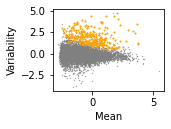

In [45]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp.png', bbox_inches='tight', dpi=300)
